In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from os import listdir


In [2]:
data_path = ['fd-1kpc-9.6sm-0-overlaid.csv/npz_subevents']
file_list = []
for path_ in data_path:
    for file_ in listdir(path_):
        file_list.append(os.path.join(path_, file_))
file_list.sort()

In [9]:
siglist=[]
for items in file_list:
    data = np.load( items )
    siglist.append(data['sig'])

sigindex=np.array(file_list, dtype='U')[np.array(siglist, dtype=int)!=0]
bkgindex=np.array(file_list, dtype='U')[np.array(siglist, dtype=int)==0]
print(len(sigindex))
print(len(bkgindex))

906
3094


In [3]:
from torch.utils.data import Dataset, DataLoader, TensorDataset
class MyDataset(Dataset):
    def __init__(self, file_list_):
        self.file_list = file_list_
        self.len = len(file_list_)

    def __getitem__(self, index):
        file_name = self.file_list[index]
        data = np.load( file_name ) 
        return torch.from_numpy(data['imxz'][:, :, :]).to(torch.float), torch.from_numpy(data['imyz'][:, :, :]).to(torch.float), torch.from_numpy(data['sig']).to(torch.float)
    def __len__(self):
        return self.len

mydataset = MyDataset(file_list)
batch_size_train = 6
batch_size_test = 2


train_size = int(0.8 * len(mydataset))
test_size = len(mydataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(mydataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train,
                                            shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test,
                                            shuffle=False)                

In [4]:
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1_1 = nn.Conv2d(2, 64, 5) 
        self.conv1_2 = nn.Conv2d(2, 64, 5) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2_1 = nn.Conv2d(64, 128, 5)
        self.conv2_2 = nn.Conv2d(64, 128, 5)
        self.conv3_1 = nn.Conv2d(128, 256, 6)
        self.conv3_2 = nn.Conv2d(128, 256, 6)

        self.fc1_1 = nn.Linear(256 * 52 * 44, 50)
        self.fc1_2 = nn.Linear(256 * 52 * 44, 50)
        self.fc2= nn.Linear(100, 1)

    def forward(self, x1, x2):
        # x1, x2 shape: (896, 384)      channel = 2
        x1 = self.pool(F.relu(self.conv1_1(x1))) # shape: (448, 384)->(444, 380)->(222, 190)
        x1 = self.pool(F.relu(self.conv2_1(x1))) # shape: (222, 190)->(218, 186)->(109, 93)
        x1 = self.pool(F.relu(self.conv3_1(x1))) # shape: (109, 93)->(104, 88)->(52, 44)
        x1 = torch.flatten(x1, 1) # flatten all dimensions except batch 
        x1 = F.relu(self.fc1_1(x1))

        x2 = self.pool(F.relu(self.conv1_2(x2))) # shape: (448, 384)->(444, 380)->(222, 190)
        x2 = self.pool(F.relu(self.conv2_2(x2))) # shape: (222, 190)->(218, 186)->(109, 93)
        x2 = self.pool(F.relu(self.conv3_2(x2))) # shape: (109, 93)->(104, 88)->(52, 44)
        x2 = torch.flatten(x2, 1) # flatten all dimensions except batch 
        x2 = F.relu(self.fc1_2(x2))

        return self.fc2(torch.cat((x1, x2), 1))
net=Net().cuda()

In [5]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [6]:
sum(p.numel() for p in net.parameters())

61349193

In [7]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1660 Ti'

In [10]:
# Training
loss_list = []
alpha=0.2
epochs = 100


accuracy_list = []

for i in range(epochs):
    net.train()
    for (batch_idx, batch) in enumerate(trainloader):
        XZ_train_batch = batch[0].cuda() # remove .cuda() if you don't have a GPU
        YZ_train_batch = batch[1].cuda() # remove .cuda() if you don't have a GPU
        sig_train_batch = batch[2].cuda() # remove .cuda() if you don't have a GPU

        Netout = net.forward(XZ_train_batch, YZ_train_batch) # This will call the forward function, usually it returns tensors.
        #print(F.softmax(Netout))
        loss = criterion(Netout, sig_train_batch) # classification loss

        # Zero the gradients before running the backward pass.
        optimizer.zero_grad() 
        
        # Backward pass: compute gradient of the loss with respect to all the learnable
        # parameters of the model. Internally, the parameters of each Module are stored
        # in Tensors with requires_grad=True, so this call will compute gradients for
        # all learnable parameters in the model.
        loss.backward()
        
        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()

        loss_list.append(loss)
        if batch_idx % 50 == 0 or True:
            #print("Epoch: {}, batch: {} Loss: {} label_loss:{}".format(i, batch_idx, loss, label_loss_))
            print("Epoch: {}, batch: {} Loss: {:0.4f}".format(i, batch_idx, loss))
    
    net.eval() # begin testing
    preds = np.array([])
    reals = np.array([])

    with torch.no_grad():
        for (batch_idx, batch) in enumerate(testloader):
            XZ_test_batch = batch[0].cuda() # remove .cuda() if you don't have a GPU
            YZ_test_batch = batch[1].cuda() # remove .cuda() if you don't have a GPU
            sig_test_batch = batch[2].cuda() # remove .cuda() if you don't have a GPU

            Netout = net.forward(XZ_test_batch, YZ_test_batch) # This will call the forward function, usually it returns tensors.
            #print(Netout.shape)
            prediction=F.softmax(Netout, dim=1).argmax(dim=1)
            

            preds=np.concatenate((preds, prediction.cpu().detach().numpy().flatten()))
            reals=np.concatenate((reals, sig_test_batch.cpu().detach().numpy().flatten()))
        preds=np.array(preds)
        reals=np.array(reals)
        accuracy=np.mean(preds==reals)
        accuracy_list.append(accuracy)
        print("Test accuracy: {}".format(accuracy))

Epoch: 0, batch: 0 Loss: 2.3630
Epoch: 0, batch: 1 Loss: 7.5779
Epoch: 0, batch: 2 Loss: 2.8644
Epoch: 0, batch: 3 Loss: 0.9500
Epoch: 0, batch: 4 Loss: 2.4372
Epoch: 0, batch: 5 Loss: 4.3609
Epoch: 0, batch: 6 Loss: 1.3720
Epoch: 0, batch: 7 Loss: 1.3370
Epoch: 0, batch: 8 Loss: 1.2771
Epoch: 0, batch: 9 Loss: 4.9159
Epoch: 0, batch: 10 Loss: 2.2180
Epoch: 0, batch: 11 Loss: 0.9365
Epoch: 0, batch: 12 Loss: 4.0240
Epoch: 0, batch: 13 Loss: 0.9209
Epoch: 0, batch: 14 Loss: 0.7764
Epoch: 0, batch: 15 Loss: 7.0546
Epoch: 0, batch: 16 Loss: 0.5043
Epoch: 0, batch: 17 Loss: 5.0026
Epoch: 0, batch: 18 Loss: 0.4753
Epoch: 0, batch: 19 Loss: 0.6559
Epoch: 0, batch: 20 Loss: 0.3741
Epoch: 0, batch: 21 Loss: 0.6122
Epoch: 0, batch: 22 Loss: 0.2744
Epoch: 0, batch: 23 Loss: 7.2458
Epoch: 0, batch: 24 Loss: 8.6295
Epoch: 0, batch: 25 Loss: 2.2578
Epoch: 0, batch: 26 Loss: 1.2506
Epoch: 0, batch: 27 Loss: 0.2251
Epoch: 0, batch: 28 Loss: 0.2301
Epoch: 0, batch: 29 Loss: 0.2257
Epoch: 0, batch: 30 

KeyboardInterrupt: 

In [ ]:
siglist=[]
for items in file_list:
    data = np.load( os.path.join( data_path, items ) )
    siglist.append([items, data['sig']])

In [ ]:
siglist

In [ ]:
# Prediction
preds = []
reals = []

for (batch_idx, batch) in enumerate(testloader):
    XZ_test_batch = batch[0].cuda() # remove .cuda() if you don't have a GPU
    YZ_test_batch = batch[1].cuda() # remove .cuda() if you don't have a GPU
    sig_test_batch = batch[2].cuda() # remove .cuda() if you don't have a GPU

    Netout = net.forward(XZ_test_batch, YZ_test_batch) # This will call the forward function, usually it returns tensors.
    #print(Netout.shape)
    prediction=Netout
    #print(predictor)

    preds.append(prediction.cpu().detach().numpy())
    
    reals.append(sig_test_batch.cpu().detach().numpy())
preds=np.array(preds)
reals=np.array(reals)

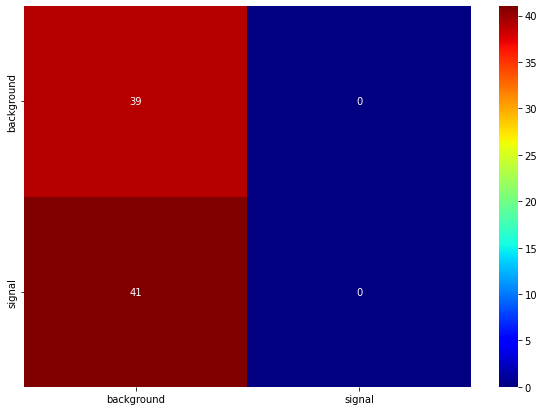

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(confusion_matrix(reals.flatten(), preds.flatten()), index = ['background', 'signal'],
                  columns = ['background', 'signal'])
plt.figure(figsize = (10,7))
plt.xlabel('Predicted')
plt.ylabel('Actual')
sn.heatmap(df_cm, annot=True, cmap="jet")
plt.show()

# Confusion matrix whose i-th row and j-th column entry indicates the number of samples with true label being i-th class and predicted label being j-th class.

In [ ]:
np.sum(reals.flatten())

41.0

In [ ]:
torch.save(net, './model_save_train_VGG_reduced_time.pth')

In [ ]:
net = torch.load('./model_save_train_VGG_reduced_time.pth')


In [ ]:
confusion_matrix(reals.flatten(), preds.flatten())

array([[ 45,  12],
       [  8, 335]], dtype=int64)

In [ ]:
preds

array([[[0.40362734],
        [0.40550905]],

       [[0.22553435],
        [0.40490067]],

       [[0.39987746],
        [0.40550905]],

       [[0.39987746],
        [0.40550905]],

       [[0.39987746],
        [0.40613887]],

       [[0.4067989 ],
        [0.40631136]],

       [[0.22553435],
        [0.40345606]],

       [[0.4066822 ],
        [0.4066822 ]],

       [[0.22553435],
        [0.40550905]],

       [[0.40631136],
        [0.40550905]],

       [[0.40362734],
        [0.4067989 ]],

       [[0.40631136],
        [0.40550905]],

       [[0.40550905],
        [0.22553435]],

       [[0.40345606],
        [0.40631136]],

       [[0.40550905],
        [0.40613887]],

       [[0.40490067],
        [0.40490067]],

       [[0.4067989 ],
        [0.4067989 ]],

       [[0.40490067],
        [0.40550905]],

       [[0.40345606],
        [0.40490067]],

       [[0.40345606],
        [0.4067989 ]],

       [[0.40631136],
        [0.39987746]],

       [[0.40631136],
        [0.4